In [1]:
import torch
import torch.nn.functional as F
from typing import Tuple,List

from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

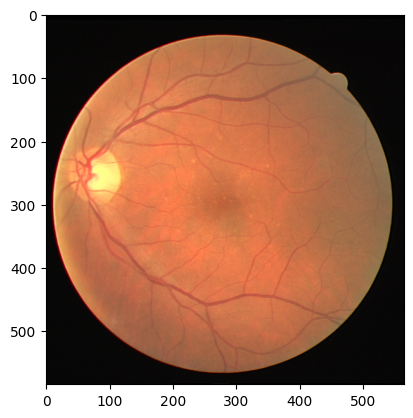

In [2]:
img_path = "../data/DRIVE/training/images/21_training.tif"
pil_img = Image.open(img_path).convert("RGB")
img_tensor = TF.to_tensor(pil_img)
plt.figure()
plt.imshow(img_tensor.permute(1, 2, 0))

In [3]:
img = img_tensor

if img.dim() == 2:
    img = img.unsqueeze(0)     # (1,H,W)
elif img.dim() != 3:
    raise ValueError(f"img must be 2D or 3D tensor, got shape {img.shape}")

C,H,W = img.shape
orig_size = (H,W)

print(img.shape)

torch.Size([3, 584, 565])


(640, 640)


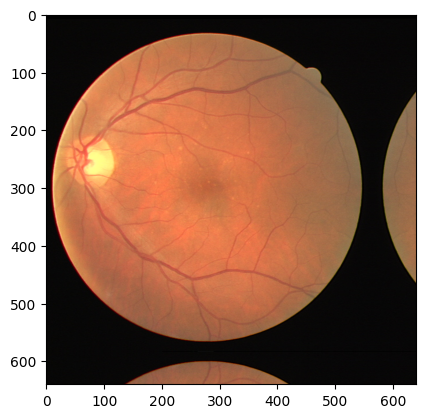

In [4]:
patch_size = 128
padding_mode = "reflect"

pad_h = (patch_size - H % patch_size) % patch_size
pad_w = (patch_size - W % patch_size) % patch_size

padding = (0,pad_w,0,pad_h)

if pad_h > 0 or pad_w > 0:
    img_padded = F.pad(img, padding, mode=padding_mode)
else:
    img_padded = img

plt.figure()
plt.imshow(img_padded.permute(1, 2, 0))

_,Hp,Wp = img_padded.shape

padded_size = (Hp,Wp)
print(padded_size)

In [5]:
patches = img_padded.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
print(patches.shape)

torch.Size([3, 5, 5, 128, 128])


In [6]:
num_patches_h = patches.size(1)
num_patches_w = patches.size(2)

# 调整维度顺序并展平为 (N, C, patch_size, patch_size)
# 1) 调整维度顺序
patches = patches.permute(1, 2, 0, 3, 4)
print(patches.shape)

# 2) 使内存连续
patches = patches.contiguous()
print(patches.shape)

# 3) 展平为 (N, C, ph, pw)
patches = patches.view(-1, C, patch_size, patch_size)
print(patches.shape)

torch.Size([5, 5, 3, 128, 128])
torch.Size([5, 5, 3, 128, 128])
torch.Size([25, 3, 128, 128])


In [7]:
coords: List[Tuple[int, int]] = []
for i in range(num_patches_h):
    for j in range(num_patches_w):
        top = i * patch_size
        left = j * patch_size
        coords.append((top, left))

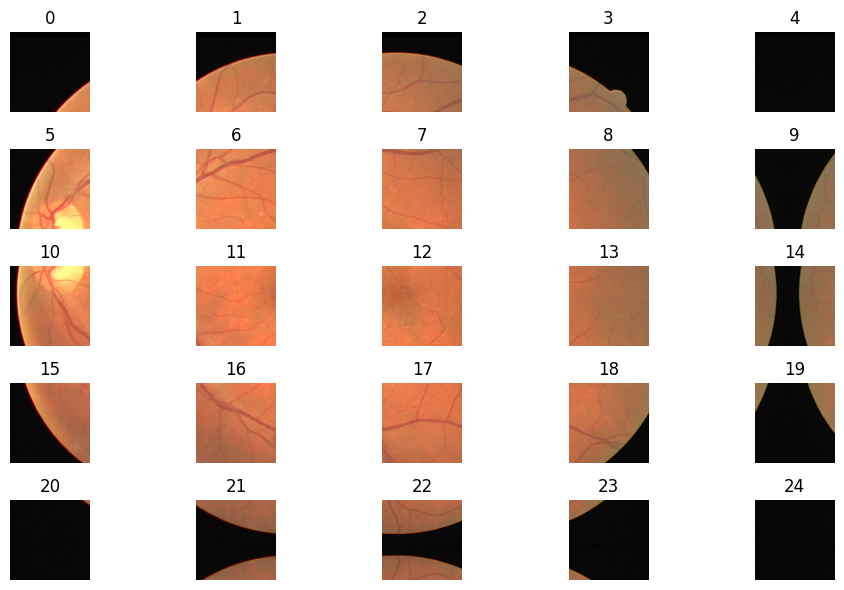

In [8]:
import math

N = patches.size(0)   # 总 patch 数，比如 25
cols = 5              # 每行 5 张
rows = math.ceil(N / cols)

# 整体画布小一点，每个子图就更小；可以自己改 (比如 8, 6)
plt.figure(figsize=(10, 6))

for i, patch in enumerate(patches):
    ax = plt.subplot(rows, cols, i + 1)

    # [C, H, W] -> [H, W, C]
    img_np = patch.detach().cpu().permute(1, 2, 0).numpy()

    ax.imshow(img_np)
    ax.set_title(f"{i}")
    ax.axis("off")

plt.tight_layout()
plt.show()
